<a href="https://colab.research.google.com/github/LinYuanxi/ML/blob/main/%D0%9C%D0%9C%D0%9E_%D0%9B%D0%A04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from IPython.display import Image
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from surprise import SVD, Dataset, Reader
from surprise.model_selection import PredefinedKFold
from collections import defaultdict
from surprise.accuracy import rmse
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline 
sns.set(style="ticks")

In [100]:
df_movies_all = pd.read_csv('movies.csv')

In [101]:
df_movies_all.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [175]:
df_movies_all.shape

(34208, 3)

In [92]:
df_ratings = pd.read_csv('ratings.csv')

In [97]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,169.0,2.5,1.204928e+09
1,1,2471.0,3.0,1.204927e+09
2,1,48516.0,5.0,1.204927e+09
3,2,2571.0,3.5,1.436165e+09
4,2,109487.0,4.0,1.436165e+09


In [94]:
df_ratings.shape

(331981, 4)

In [95]:
df_links = pd.read_csv('links.csv')

In [96]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [98]:
# Преобразуем идентификаторы к типу int
links_ids = df_links[df_links['tmdbId'].notnull()]['tmdbId'].astype('int')

In [103]:
# Оставляем только фильмы, которые есть в df_links
df_movies = df_movies_all[df_movies_all['movieId'].isin(links_ids)]

In [105]:
df_movies_all.shape, df_movies.shape

((34208, 3), (5855, 3))

Выбор идентификаторов для связи таблиц

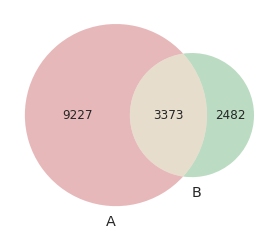

In [109]:
# movieId в таблице рейтингов не соответствует id в основной таблице
venn2([set(df_ratings['movieId'].unique()), set(df_movies['movieId'].unique())])

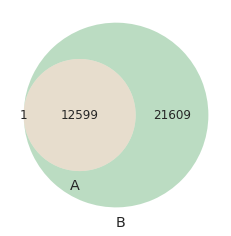

In [111]:
# movieId в таблице рейтингов совпадает с movieId в таблице связей
venn2([set(df_ratings['movieId'].unique()), set(df_links['movieId'].unique())])

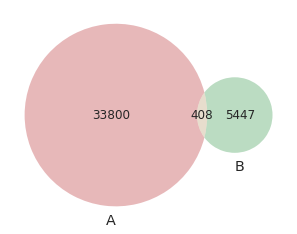

In [114]:
venn2([set(df_links['imdbId'].unique()), set(df_movies['movieId'].unique())])

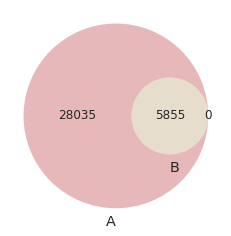

In [116]:
venn2([set(df_links['tmdbId'].unique()), set(df_movies['movieId'].unique())])

Векторизация описания фильмов

In [119]:
# У некоторых фильмов отсутствует описание
df_movies_with_genres = df_movies[df_movies['genres'].notnull()]
df_movies_with_genres = df_movies_with_description[~df_movies_with_description['genres'].str.isspace()]

In [120]:
imdb = df_movies_with_genres['movieId'].values
imdb[0:5]

array([ 2,  3,  5,  6, 11])

In [121]:
title = df_movies_with_genres['title'].values
title[0:5]

array(['Jumanji (1995)', 'Grumpier Old Men (1995)',
       'Father of the Bride Part II (1995)', 'Heat (1995)',
       'American President, The (1995)'], dtype=object)

In [122]:
genres = df_movies_with_genres['genres'].values
genres[0:5]

array(['Adventure|Children|Fantasy', 'Comedy|Romance', 'Comedy',
       'Action|Crime|Thriller', 'Comedy|Drama|Romance'], dtype=object)

In [123]:
%%time
tfidfv = TfidfVectorizer()
genres_matrix = tfidfv.fit_transform(genres)
genres_matrix

CPU times: user 46.2 ms, sys: 1.88 ms, total: 48.1 ms
Wall time: 53.9 ms


Фильтрация на основе содержания

In [136]:
class SimpleKNNRecommender:
    
    def __init__(self, X_matrix, X_ids, X_title, X_description):
        """
        Входные параметры:
        X_matrix - обучающая выборка (матрица объект-признак)
        X_ids - массив идентификаторов объектов
        X_title - массив названий объектов
        X_description - массив описаний объектов
        """
        #Сохраняем параметры в переменных объекта
        self._X_matrix = X_matrix
        self.df = pd.DataFrame(
            {'id': pd.Series(X_ids, dtype='int'),
            'title': pd.Series(X_title, dtype='str'),
            'genres': pd.Series(X_description, dtype='str'),
            'dist': pd.Series([], dtype='float')})
            
            
    def recommend_for_single_object(self, K: str, \
                X_matrix_object, cos_flag = True, manh_flag = False):
        """
        Метод формирования рекомендаций для одного объекта.
        Входные параметры:
        K - количество рекомендуемых соседей 
        X_matrix_object - строка матрицы объект-признак, соответствующая объекту
        cos_flag - флаг вычисления косинусного расстояния
        manh_flag - флаг вычисления манхэттэнского расстояния
        Возвращаемое значение: K найденных соседей
        """
        
        scale = 1000000
        # Вычисляем косинусную близость
        if cos_flag:
            dist = cosine_similarity(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=False)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] < scale]
        
        else:
            if manh_flag:
                dist = manhattan_distances(self._X_matrix, X_matrix_object)
            else:
                dist = euclidean_distances(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=True)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] > 0.0]            
        
        # Оставляем К первых рекомендаций
        res = res.head(K)
        return res

In [137]:
# Тестовый пример - будем искать фильмы, похожие на skams
Addiction_ind = 107
title[Addiction_ind]

'Addiction, The (1995)'

In [138]:
Addiction_matrix = genres_matrix[Addiction_ind]
Addiction_matrix

<1x24 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [139]:
skr1 = SimpleKNNRecommender(genres_matrix, imdb, title, genres)

In [140]:
# 20 фильмов похожих на звездные войны
# в порядке убывания схожести на основе косинусного сходства
rec1 = skr1.recommend_for_single_object(20, Addiction_matrix)
rec1

,id,title,genres,dist
4184,63069,Guinea Pig: Flowers of Flesh and Blood (Za gin...,Horror,895395.883184
2165,5551,"Return of the Vampire, The (1944)",Horror,895395.883184
5709,139519,One Missed Call 3: Final (2006),Horror,895395.883184
2172,5595,Shock Waves (1977),Horror,895395.883184
2205,5731,"Entity, The (1981)",Horror,895395.883184
4164,61638,Flu Bird (2008),Horror,895395.883184
2196,5717,Make Them Die Slowly (Cannibal Ferox) (1981),Horror,895395.883184
2203,5726,Dead & Buried (1981),Horror,895395.883184
2161,5546,976-EVIL (1989),Horror,895395.883184
2227,5844,"Prowler, The (a.k.a. Rosemary's Killer) (a.k.a...",Horror,895395.883184


In [141]:
# При поиске с помощью Евклидова расстояния получаем такой же результат
rec2 = skr1.recommend_for_single_object(20, Addiction_matrix, cos_flag = False)
rec2

,id,title,genres,dist
3161,27351,Spiral (2000),Horror,457392.865742
1304,2119,Maximum Overdrive (1986),Horror,457392.865742
5520,127585,Fear Clinic (2014),Horror,457392.865742
4256,68590,Horrorvision (2001),Horror,457392.865742
5486,126056,Coven (2000),Horror,457392.865742
4164,61638,Flu Bird (2008),Horror,457392.865742
2256,5925,"Beast Within, The (1982)",Horror,457392.865742
4727,86463,"Silent Night, Deadly Night III: Better Watch O...",Horror,457392.865742
4228,66066,"Grudge 3, The (2009)",Horror,457392.865742
4226,65994,"Dead Calling, A (2006)",Horror,457392.865742


In [142]:
# Манхэттэнское расстояние дает нерелевантные результаты поиска
rec3 = skr1.recommend_for_single_object(15, Addiction_matrix, 
                                        cos_flag = False, manh_flag = True)
rec3

,id,title,genres,dist
4318,71203,Laid To Rest (2009),Horror,549875.059475
5675,137409,Phantom of the Mall: Eric's Revenge (1989),Horror,549875.059475
1538,2789,Damien: Omen II (1978),Horror,549875.059475
2205,5731,"Entity, The (1981)",Horror,549875.059475
1536,2787,Cat's Eye (1985),Horror,549875.059475
4964,97035,"Living Skeleton, The (Kyûketsu dokuro-sen) (1968)",Horror,549875.059475
132,177,Lord of Illusions (1995),Horror,549875.059475
3946,52660,Night of the Ghouls (1959),Horror,549875.059475
2135,5413,Zombie Holocaust (a.k.a. Doctor Butcher M.D.) ...,Horror,549875.059475
5064,102078,Albino Farm (2009),Horror,549875.059475


Коллаборативная фильтрация

In [143]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,169.0,2.5,1.204928e+09
1,1,2471.0,3.0,1.204927e+09
2,1,48516.0,5.0,1.204927e+09
3,2,2571.0,3.5,1.436165e+09
4,2,109487.0,4.0,1.436165e+09


In [144]:
# Количество уникальных пользователей
len(df_ratings['userId'].unique())

3644

In [145]:
# Количество уникальных фильмов
len(df_ratings['movieId'].unique())

12600

In [146]:
# Сформируем матрицу взаимодействий на основе рейтингов
# Используется идея из статьи - https://towardsdatascience.com/beginners-guide-to-creating-an-svd-recommender-system-1fd7326d1f65
def create_utility_matrix(data):
    itemField = 'movieId'
    userField = 'userId'
    valueField = 'rating'  
    
    userList = data[userField].tolist()
    itemList = data[itemField].tolist()
    valueList = data[valueField].tolist()    
    
    users = list(set(userList))
    items = list(set(itemList))    
    
    users_index = {users[i]: i for i in range(len(users))}    
    pd_dict = {item: [0.0 for i in range(len(users))] for item in items}    
    
    for i in range(0,data.shape[0]):
        item = itemList[i]
        user = userList[i]
        value = valueList[i]    
        pd_dict[item][users_index[user]] = value    
    
    X = pd.DataFrame(pd_dict)
    X.index = users
        
    itemcols = list(X.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}
    
    return X, users_index, items_index

In [148]:
%%time
user_item_matrix, users_index, items_index = create_utility_matrix(df_ratings)

CPU times: user 11.3 s, sys: 799 ms, total: 12.1 s
Wall time: 12.7 s


In [149]:
user_item_matrix

,NaN,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,98239.0,98243.0,32707.0,131013.0,131017.0,32721.0,32735.0,32743.0,65514.0,98296.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3642,0.0,3.0,3.0,3.0,0.0,3.0,3.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3643,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [208]:
# Выделение тестовой строки
user_item_matrix__test = user_item_matrix.loc[[107]]
user_item_matrix__test

,NaN,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,98239.0,98243.0,32707.0,131013.0,131017.0,32721.0,32735.0,32743.0,65514.0,98296.0
107,0.0,4.0,0.0,3.0,0.0,1.0,3.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [209]:
# Оставшаяся часть матрицы для обучения
user_item_matrix__train = user_item_matrix.loc[:412]
user_item_matrix__train

,NaN,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,98239.0,98243.0,32707.0,131013.0,131017.0,32721.0,32735.0,32743.0,65514.0,98296.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
user_item_matrix__train.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Построение модели на основе SVD

In [211]:
%%time
U, S, VT = np.linalg.svd(user_item_matrix__train.T)
V = VT.T

CPU times: user 1min 10s, sys: 1.16 s, total: 1min 11s
Wall time: 37.4 s


In [212]:
# Матрица соотношения между пользователями и латентными факторами
U.shape

(12600, 12600)

In [213]:
# Матрица соотношения между объектами и латентными факторами
V.shape

(411, 411)

In [214]:
S.shape

(411,)

In [215]:
Sigma = np.diag(S)
Sigma.shape

(411, 411)

In [216]:
# Матрица соотношения между объектами и латентными факторами
V.shape

(411, 411)

In [217]:
S.shape

(411,)

In [218]:
# Диагональная матрица сингулярных значений
Sigma

array([[306.01794426,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 140.44576119,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 117.89790173, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   2.37716709,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          2.28985357,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.91639647]])

In [219]:
# Используем 3 первых сингулярных значения
r=3
Ur = U[:, :r]
Sr = Sigma[:r, :r]
Vr = V[:, :r]

In [220]:
# Матрица соотношения между новым пользователем и латентными факторами
test_user = np.mat(user_item_matrix__test.values)
test_user.shape, test_user

((1, 12600), matrix([[0., 4., 0., ..., 0., 0., 0.]]))

In [221]:
tmp = test_user * Ur * np.linalg.inv(Sr)
tmp

matrix([[-0.0105167 ,  0.00863945, -0.00727682]])

In [222]:
test_user_result = np.array([tmp[0,0], tmp[0,1], tmp[0,2]])
test_user_result

array([-0.0105167 ,  0.00863945, -0.00727682])

In [223]:
# Вычисляем косинусную близость между текущим пользователем 
# и остальными пользователями
cos_sim = cosine_similarity(Vr, test_user_result.reshape(1, -1))
cos_sim[:10]

array([[-0.22102287],
       [-0.4366536 ],
       [ 0.091579  ],
       [-0.48447305],
       [ 0.99668235],
       [-0.12587623],
       [ 0.98702029],
       [ 0.41684651],
       [ 0.13224137],
       [ 0.96450934]])

In [224]:
# Преобразуем размерность массива
cos_sim_list = cos_sim.reshape(-1, cos_sim.shape[0])[0]
cos_sim_list[:10]

array([-0.22102287, -0.4366536 ,  0.091579  , -0.48447305,  0.99668235,
       -0.12587623,  0.98702029,  0.41684651,  0.13224137,  0.96450934])

In [225]:
# Находим наиболее близкого пользователя
recommended_user_id = np.argsort(-cos_sim_list)[0]
recommended_user_id

105

In [226]:
# Получение названия фильма
movieId_list = list(user_item_matrix.columns)
def film_name_by_movieid(ind):
    try:
        movieId = movieId_list[ind]
        flt_links = df_links[df_links['movieId'] == movieId]
        tmdbId = int(flt_links['tmdbId'].values[0])
        md_links = df_movies[df_movies['movieId'] == tmdbId]
        res = md_links['title'].values[0]
        return res
    except:
        return '' 

In [227]:
# Фильмы, которые оценивал текущий пользователь:
i=1
for idx, item in enumerate(np.ndarray.flatten(np.array(test_user))):
    if item > 0:
        film_title = film_name_by_movieid(idx)
        print('{} - {} - {}'.format(idx, film_title, item))
        if i==20:
            break
        else:
            i+=1

1 - Manny & Lo (1996) - 4.0
3 -  - 3.0
5 -  - 1.0
6 - East of Eden (1955) - 3.0
7 -  - 3.0
17 - Dream a Little Dream (1989) - 4.0
29 - Breakfast at Tiffany's (1961) - 4.0
32 - Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996) - 4.0
43 -  - 2.0
52 -  - 2.0
61 -  - 3.0
64 -  - 2.0
74 -  - 3.0
93 -  - 3.0
137 -  - 3.0
253 - American President, The (1995) - 3.0
592 - Vanishing Point (1971) - 2.0
594 - Mixed Nuts (1994) - 4.0
595 -  - 3.0
598 -  - 3.0


In [228]:
# Фильмы, которые оценивал наиболее схожий пользователь:
i=1
recommended_user_item_matrix = user_item_matrix.loc[[recommended_user_id+1]]
for idx, item in enumerate(np.ndarray.flatten(np.array(recommended_user_item_matrix))):
    if item > 0:
        film_title = film_name_by_movieid(idx)
        print('{} - {} - {}'.format(idx, film_title, item))
        if i==20:
            break
        else:
            i+=1 

1 - Manny & Lo (1996) - 2.5
2 - Camera Buff (Amator) (1979) - 3.0
6 - East of Eden (1955) - 3.5
10 - Celtic Pride (1996) - 3.0
16 - Rudy (1993) - 4.5
19 -  - 3.0
32 - Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996) - 4.0
34 -  - 3.0
39 -  - 3.0
47 - Rendezvous in Paris (Rendez-vous de Paris, Les) (1995) - 4.0
50 - Rude (1995) - 3.5
94 -  - 2.0
103 -  - 3.5
109 - Stars Fell on Henrietta, The (1995) - 4.0
110 - Unforgettable (1996) - 4.0
140 -  - 0.5
144 - Bhaji on the Beach (1993) - 3.5
152 - Mangler, The (1995) - 2.0
154 -  - 3.0
155 - It's All About Love (2003) - 3.0
